In [1]:
import os
import numpy as np
import pickle
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from Week567_General_Code_Question import load_mnist

In [2]:
batch_size = 128
train_loader, test_loader = load_mnist(batch_size=batch_size)
mnist_dim = 28 * 28
z_dim = 64

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim, mnist_dim):
        super(Generator, self).__init__()
        # TODO：定义Generator的结构
        self.deconv1 = nn.ConvTranspose2d(z_dim, 256, kernel_size=3, stride=2)
        torch.nn.init.normal_(self.deconv1.weight, 0.0, 0.02)
        self.bn1 = nn.BatchNorm2d(256)
        torch.nn.init.normal_(self.bn1.weight, 0.0, 0.02) 
        torch.nn.init.constant_(self.bn1.bias, 0)

        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=1)
        torch.nn.init.normal_(self.deconv2.weight, 0.0, 0.02)
        self.bn2 = nn.BatchNorm2d(128)
        torch.nn.init.normal_(self.bn2.weight, 0.0, 0.02) 
        torch.nn.init.constant_(self.bn2.bias, 0)

        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2)
        torch.nn.init.normal_(self.deconv3.weight, 0.0, 0.02)
        self.bn3 = nn.BatchNorm2d(64)
        torch.nn.init.normal_(self.bn3.weight, 0.0, 0.02) 
        torch.nn.init.constant_(self.bn3.bias, 0)

        self.deconv4 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2)
        torch.nn.init.normal_(self.deconv4.weight, 0.0, 0.02)

    def forward(self, x):
        # TODO：前向传播
        x = x.view(len(x), 64, 1, 1)
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = F.relu(self.bn3(self.deconv3(x)))
        x = torch.tanh(self.deconv4(x))
        return x

class Discriminator(nn.Module):
    def __init__(self, mnist_dim):
        super(Discriminator, self).__init__()
        # TODO：定义Discriminator结构
        self.conv1 = nn.Conv2d(1, 16, kernel_size=4, stride=2)
        torch.nn.init.normal_(self.conv1.weight, 0.0, 0.02)
        self.bn1 = nn.BatchNorm2d(16)
        torch.nn.init.normal_(self.bn1.weight, 0.0, 0.02) 
        torch.nn.init.constant_(self.bn1.bias, 0)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        torch.nn.init.normal_(self.conv2.weight, 0.0, 0.02)
        self.bn2 = nn.BatchNorm2d(32)
        torch.nn.init.normal_(self.bn2.weight, 0.0, 0.02) 
        torch.nn.init.constant_(self.bn2.bias, 0)

        self.conv3 = nn.Conv2d(32, 1, kernel_size=4, stride=2)
        torch.nn.init.normal_(self.conv3.weight, 0.0, 0.02)
        # self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # TODO：前向传播
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = self.conv3(x)
        x = torch.sigmoid(x)
        x = x.view(len(x), -1)
        return x

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G = Generator(z_dim, mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)
print(G, D)

Generator(
  (deconv1): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
) Discriminator(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 1, kernel_size=(4, 4), stride=(2, 2))
)


In [5]:
lr = 0.0002
criterion = nn.BCELoss()
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
G_loss_history = []
D_loss_history = []

In [6]:
epochs = 30 #30
for e in range(epochs):
    # TODO：在这里对train_loader做遍历，训练GAN
    D_loss_sum = 0.0 # 判别器累计损失
    G_loss_sum = 0.0 # 生成器累计损失
    num_batches = 0 # 统计batch数量

    for data in train_loader:
        real_images, _ = data
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # 1. 训练Discriminator
        D_optimizer.zero_grad() # 判别器梯度清零

        D_real = D(real_images) # 判别器对真实图像的判断
        labels_real = torch.ones((batch_size, 1),).to(device) * 0.9  # 使用平滑标签
        D_real_loss = criterion(D_real, labels_real) # 判别器对真实图像的损失

        z = torch.randn(batch_size, z_dim).to(device) # 随机噪声
        fake_images = G(z) # 生成器生成假图像
        D_fake = D(fake_images.detach()) # 固定生成器梯度，判断假图像
        labels_fake = torch.zeros(batch_size, 1).to(device) + 0.1  # 使用平滑标签
        D_fake_loss = criterion(D_fake, labels_fake) # 判别器对假图像的损失
        
        D_loss = (D_real_loss + D_fake_loss) / 2 # 平均损失
        D_loss.backward()
        D_optimizer.step() # 更新判别器

        # 2. 训练Generator
        # for _ in range(2):
        G_optimizer.zero_grad()

        z = torch.randn(batch_size, z_dim).to(device) # 随机噪声
        fake_images = G(z) # 生成器生成假图像
        D_fake = D(fake_images)  # 判别器对假图像的判断
        loss_G = criterion(D_fake, torch.ones(batch_size, 1).to(device))  # 让D判别假图像为真图像
        loss_G.backward()
        G_optimizer.step()

        D_loss_sum += D_loss.item() # 累计判别器损失
        G_loss_sum += loss_G.item() # 累计生成器损失
        num_batches += 1

    # TODO：你需要额外存储Discriminator在当前epoch内各个batch的平均loss
    D_loss_avg = D_loss_sum / num_batches
    # TODO：你需要额外存储Generator在当前epoch内各个batch的平均loss
    G_loss_avg = G_loss_sum / num_batches
    
    print('epoch %d: D_loss %.3f, G_loss %.3f' % (e, D_loss_avg, G_loss_avg))
    D_loss_history.append(D_loss_avg)
    G_loss_history.append(G_loss_avg)

epoch 0: D_loss 0.583, G_loss 0.854
epoch 1: D_loss 0.592, G_loss 1.026
epoch 2: D_loss 0.636, G_loss 0.801
epoch 3: D_loss 0.619, G_loss 0.836
epoch 4: D_loss 0.620, G_loss 0.865
epoch 5: D_loss 0.631, G_loss 0.827
epoch 6: D_loss 0.644, G_loss 0.801
epoch 7: D_loss 0.654, G_loss 0.783
epoch 8: D_loss 0.669, G_loss 0.762
epoch 9: D_loss 0.675, G_loss 0.750
epoch 10: D_loss 0.682, G_loss 0.740
epoch 11: D_loss 0.691, G_loss 0.729
epoch 12: D_loss 0.692, G_loss 0.721
epoch 13: D_loss 0.693, G_loss 0.720
epoch 14: D_loss 0.694, G_loss 0.717
epoch 15: D_loss 0.695, G_loss 0.714
epoch 16: D_loss 0.695, G_loss 0.711
epoch 17: D_loss 0.694, G_loss 0.710
epoch 18: D_loss 0.695, G_loss 0.709
epoch 19: D_loss 0.695, G_loss 0.708
epoch 20: D_loss 0.695, G_loss 0.706
epoch 21: D_loss 0.696, G_loss 0.706
epoch 22: D_loss 0.697, G_loss 0.703
epoch 23: D_loss 0.696, G_loss 0.703
epoch 24: D_loss 0.697, G_loss 0.703
epoch 25: D_loss 0.696, G_loss 0.701
epoch 26: D_loss 0.696, G_loss 0.701
epoch 27: D

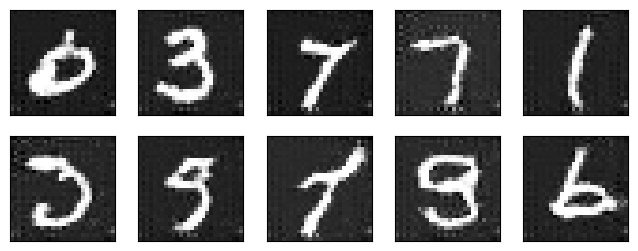

In [7]:
G.eval()
G_gen = G(torch.randn((10, z_dim), device=device))
imgs = G_gen.detach().cpu().data.numpy().reshape(G_gen.shape[0], 28, 28)

fig = plt.figure(figsize=(8, 3))
for idx, img in enumerate(imgs):
    ax = fig.add_subplot(2, 5, idx + 1)
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

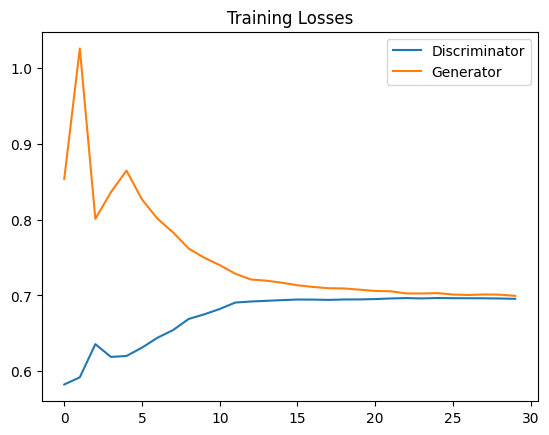

In [8]:
fig, ax = plt.subplots()
plt.plot(np.array(D_loss_history), label='Discriminator')
plt.plot(np.array(G_loss_history), label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()